## ML Fundamentals with PyTorch - MNIST Digit Prediction

As part of my journey to learn the fundamentals of machine learning, I did a project using the popular MNIST dataset. My goal was to build a neural network from scratch, train it to recognize handwritten digits with PyTorch. Here's a detailed account of what I did, step by step.




## Step 1: Imported Necessary Libraries
The first step of my project was to assemble the tools needed for the task.  I imported the essential libraries that would help me build and train my neural network.  
There are a lot of great videos on YT to do the same.

In [1]:
from torch import nn
from torch.optim import Adam
from torch.nn import Module
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [2]:
import torch
import torchvision

## Step 2: Set Hyperparameters
Setting the stage for training my model, I defined the hyperparameters. These values would guide the learning process, and I like doing this early because if I want to change any of this and run this model again I can just change it on the top and rerun all the cells.

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Step 3: Load the MNIST Dataset
Then, I proceeded to load the MNIST dataset. This dataset of handwritten digits would be the foundation upon which my model would learn to recognize patterns.
The download failed a few times but I think this was an error with the Datasets from PyTorch compared to the code itself.



In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5044988.67it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134998.11it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1094627.47it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11353116.07it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



## Step 4: Visualize Sample Data
Before diving into the training process, I took a moment to visualize some sample data. This step is to preview the material before diving into the task at hand.
I like to get a feel for the data specially when it is a visual model. It just gives you a small step of reinforcement saying that I have done sth worthwhile.

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

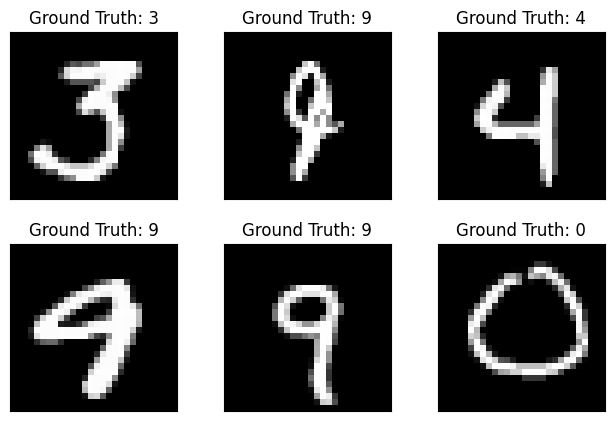

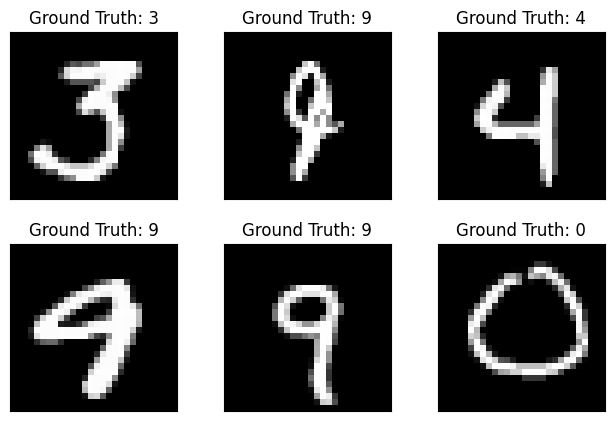

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Step 5: Define the Neural Network Architecture
Next, I defined the architecture of my neural network. This was the blueprint that would determine how the network processes the data and learns to recognize digits.  
This is the most important step in the whole model building process in my opinion after processing the data which is not needed when working with clean datasets like MNIST.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

## Step 6: Define the Optimizer and Loss Function
To train the network, I defined the optimizer and loss function. These components would guide the network's learning process.

A definition of optimizers and loss functions are:   
They tie together the loss function and model parameters by updating the model in response to the output of the loss function. In simpler terms, *optimizers* shape and mold your model into its most accurate possible form by futzing with the weights.  
 The *loss function*  is the guide to the terrain, telling the optimizer when it’s moving in the right or wrong direction.

 Read an article here: https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#:~:text=They%20tie%20together%20the%20loss,by%20futzing%20with%20the%20weights.

In [10]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

## Step 7: Definining Training
With everything in place, I began to define the training process. This step was the culmination of all the preparations, to get the model/network to learn from the data through a series of iterations.

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

## Step 8: Defining the Model
After defining training the model, I defined its testing. Most programs integrate the two but I like to build this iteratively.

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

## Step 9: Putting the model in training mode
In this step we put the model in training mode. As we can see the loss is pretty good which means the code is solid.  
This step is optional but I like to do it as it gives me more control over my model. I can stop training the model here and change the architecure if the loss isn't good.

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-9-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687643
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426571
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284097
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.317448
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.448295
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140931
Train Epoch: 1 [12160/6

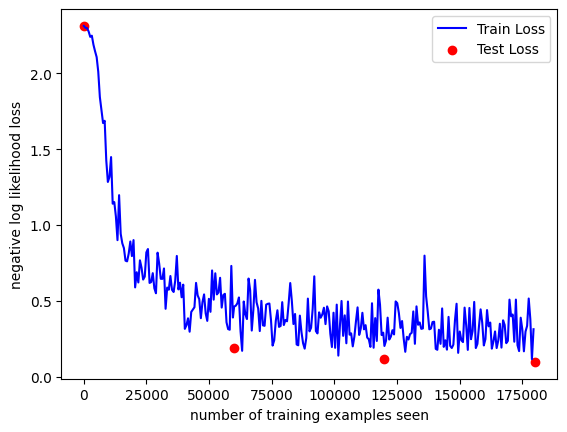

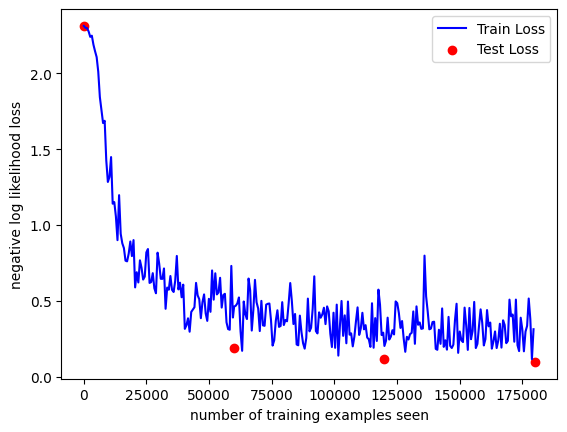

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig


## Step 10 : Judging on the example data
We check to see how the model performs on the example data. This informs if we should go back and change the architecture or continue training the model.

In [16]:
with torch.no_grad():
  output = network(example_data)

<ipython-input-9-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


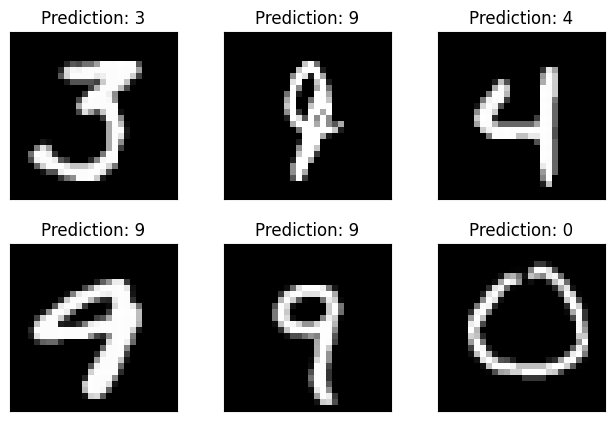

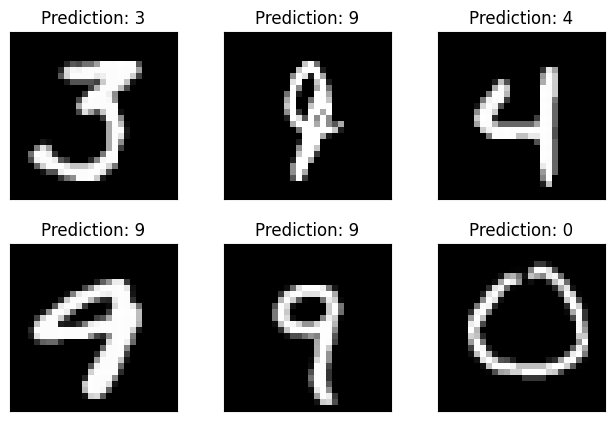

In [17]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Step 11: Creating an Optimizer and Model Saving Path
As we can see the model is doing good on the example data. This means we can save this model and the optimizer and later ammend it as we train more.

In [18]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [19]:
# Provide the path to the saved state dictionaries
network_state_dict = torch.load('model.pth')  # Replace with actual path
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth')  # Replace with actual path
continued_optimizer.load_state_dict(optimizer_state_dict)

## Step 12: Training and Testing the Model
Here we train and test the model.

In [20]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

<ipython-input-9-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.189322
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.366189
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.343270
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.374212
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.499028
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.149994
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.267188
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.309622
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.155924
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.197287
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.161895
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.142287
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.218711
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.402981
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.447489
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.155473
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.159139
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.461045
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.137765
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.245168
Train Epoch: 4 [12800/60000 (

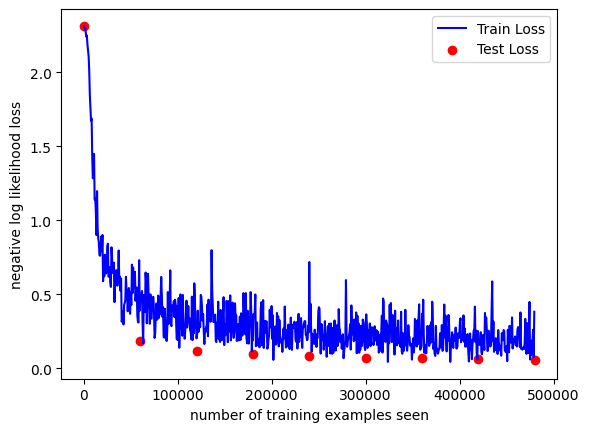

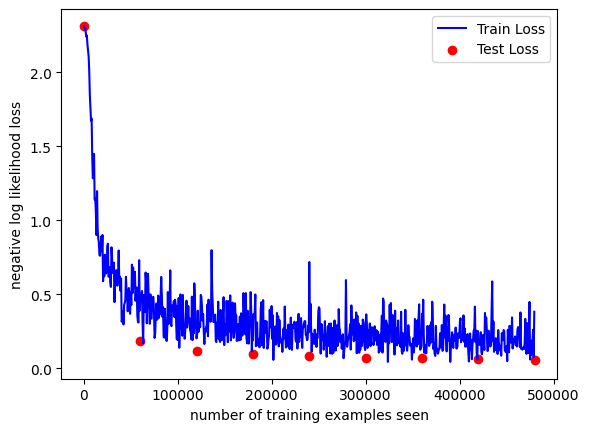

In [21]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

## Step 13: Getting the model ready to predict the handwritten digits.

In [22]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import io
import torchvision.transforms as transforms

In [23]:
def upload_and_process_image():
    uploaded = files.upload()
    image_name = next(iter(uploaded))
    image = Image.open(io.BytesIO(uploaded[image_name])).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # MNIST images are 28x28
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
    ])
    return transform(image).unsqueeze(0), image_name

In [24]:
def predict_digit(model, image):
    with torch.no_grad():
        output = model(image)
        prediction = output.argmax(dim=1, keepdim=True)
    return prediction.item()

Saving 6.png to 6.png


<ipython-input-9-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


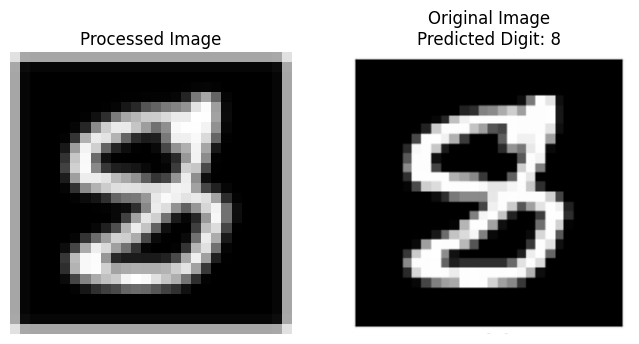

The model predicts the digit in 6.png is: 8


In [25]:
def upload_and_process_image():
    uploaded = files.upload()
    image_name = next(iter(uploaded))
    image = Image.open(io.BytesIO(uploaded[image_name])).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # MNIST images are 28x28
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
    ])
    return transform(image).unsqueeze(0), image_name, uploaded # Return the uploaded data as well

def main():
    # Upload and process the image
    processed_image, image_name, uploaded_data = upload_and_process_image() # Unpack the three returned values

    network.eval()

    # Make prediction
    predicted_digit = predict_digit(network, processed_image)

    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(processed_image.squeeze(), cmap='gray')
    plt.title(f'Processed Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Image.open(io.BytesIO(uploaded_data[image_name])))
    plt.title(f'Original Image\nPredicted Digit: {predicted_digit}')
    plt.axis('off')

    plt.show()

    print(f'The model predicts the digit in {image_name} is: {predicted_digit}')

# Run the main function
main()

This guide outlines the key steps taken in the notebook, from importing libraries to defining and training a neural network, visualizing data, and making predictions on uploaded images.